In [1]:
import yaml
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scatseisnet import ScatteringNetwork
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
plt.style.use('ggplot')

+ [读取数据](#读取数据)
+ [信号处理](#信号处理)

## 读取数据
从`yaml`文件读取参数，根据这些参数读取`.h5`文件的数据，保存为`data.npy`文件. 后续在`data.npy`文件的基础上进行训练.

yaml内容如下:
```yaml
data:
    load:
        repository: /Users/bubble/Temp  # NOTE: Modify this file path to reflect your own mount path
        events: ALL  ## 读取所有地震数据
    save: 
        filename: data.npy  ## 保存为data.npy文件
    
filter:
    start: 726    ## 地震前 24h的数据
    end: 750
    n_stations: 4  ## 读取4个台站的数据
    n_channels: 3  ## 读取3个通道的数据

```

In [2]:
# Load the YAML configuration file
with open("example.yaml", "r") as yaml_file:
    config = yaml.safe_load(yaml_file)

# Get the data repository and file names
data_repository = config['data']['load']['repository']
events = config['data']['load']['events']
save_filename = config['data']['save']['filename']

# Get the filter parameters
start_hour = config['filter']['start']
end_hour = config['filter']['end']
n_stations = config['filter']['n_stations']
n_channels = config['filter']['n_channels']

# Get a list of all the events (file paths)
if events == "ALL":
    event_files = [os.path.join(data_repository, f) for f in os.listdir(data_repository) if f.endswith(".h5")]
else:
    event_files = events

# Convert hours to sample indices
start_index = int(start_hour * 3600 * 100)
end_index = int(end_hour * 3600 * 100)

# Initialize the data array with an additional dimension for the distance
data = np.empty((len(event_files), n_stations, n_channels, end_index - start_index))

# Iterate over each event file
for event_index, event_file in enumerate(event_files):
    # Open the file
    with h5py.File(event_file, 'r') as f:
        # Get the list of stations
        stations_list = list(f.keys())

        # Select n_stations based on the closest stations (modify this part as needed)
        selected_stations = stations_list[:n_stations]

        # Extract data and distance for each selected station
        for station_index, station in enumerate(selected_stations):
            # Save seismic data
            data[event_index, station_index, :3, :] = f[station][0:3, start_index:end_index]

# Save the extracted data with distances
np.save(save_filename, data)

保存的`data.npy`文件为一个`[n_events, n_stations, n_channels, n_samples]`的`np.ndarray`
+ `n_events`是地震事件的数量
+ `n_stations`是站台的数量
+ `n_channels`是通道的数量
+ `n_samples`是每个通道的采样点数量

In [3]:
## shape=(n_events, n_stations, n_channels, n_samples)
data.shape

(1, 4, 3, 8640000)

3个通道的信号可视化，高峰为地震发生时间(以第一个站台为例)

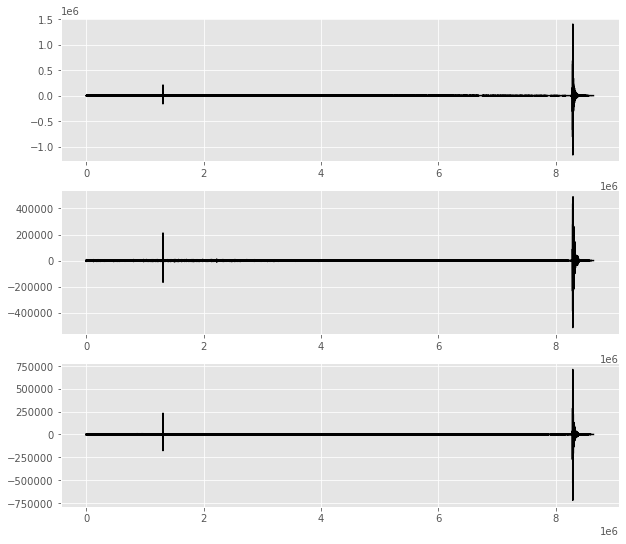

In [4]:

fig,ax=plt.subplots(3,figsize=(10,9))
ax[0].plot(data[0,0,0,:],'k-')
ax[1].plot(data[0,0,1,:],'k-')
ax[2].plot(data[0,0,2,:],'k-')

In [5]:
## 信号处理

这一部分我们会对前面的信号数据进行处理，得到一些散射系数，然后对这些系数进行聚类.具体地说，可以分为以下几个过程:
+ 构建散射网络: 前面得到的每个通道的地震信号通过这个散射网络会转化为一些散射系数，这些系数可以看作是一种特征，后续我们会对这些特征进行聚类. 我们这里选取的是一些小波网络.
+ 降维: 对应前一步得到的小波散射系数，我们会对其进行降维，这里我们选取的是PCA. 选取一些主要特征.
+ 聚类: 对于降维后的特征，我们会对其进行聚类，这里我们选取的是KMeans.

### 散射网络
使用是小波散射网络. 具体的网络结构如下图所示

In [6]:
## 参数
segment_duration_seconds = 60.0
sampling_rate_hertz = 100.0
samples_per_segment = int(segment_duration_seconds * sampling_rate_hertz)
bank_keyword_arguments = (
    {"octaves": 4, "resolution": 4, "quality": 1},
    {"octaves": 5, "resolution": 2, "quality": 3},
)

In [7]:
network = ScatteringNetwork(
    *bank_keyword_arguments,
    bins=samples_per_segment,
    sampling_rate=sampling_rate_hertz,
)

print(network)

ScatteringNetwork(bins=6000, sampling_rate=100.0, len=2)
ComplexMorletBank(bins=6000, octaves=4, resolution=4, quality=1, sampling_rate=100.0, len=16)
ComplexMorletBank(bins=6000, octaves=5, resolution=2, quality=3, sampling_rate=100.0, len=10)


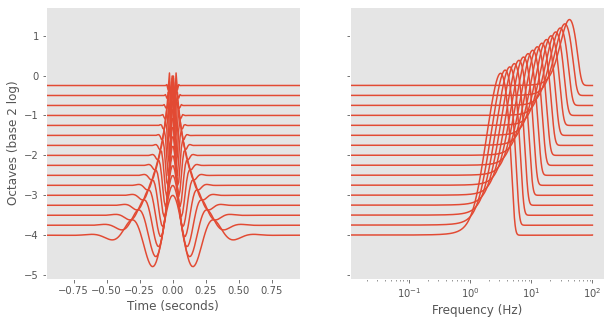

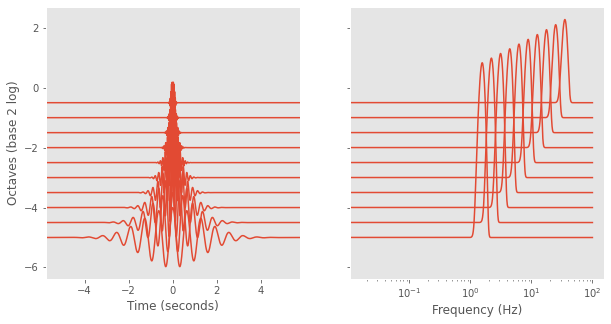

In [8]:
# Loop over network layers
for bank in network.banks:

    # Create axes (left for temporal, right for spectral domain)
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

    # Show each wavelet
    for wavelet, spectrum, ratio in zip(
        bank.wavelets, bank.spectra, bank.ratios
    ):

        # Time domain
        _=ax[0].plot(bank.times, wavelet.real + ratio, "C0")

        # Spectral domain (log of amplitude)
        _=ax[1].plot(bank.frequencies, np.log(np.abs(spectrum) + 1) + ratio, "C0")

    # Limit view to three times the temporal width of largest wavelet
    width_max = 3 * bank.widths.max()

    # Labels
    _=ax[0].set_ylabel("Octaves (base 2 log)")
    _=ax[0].set_xlabel("Time (seconds)")
    _=ax[0].set_xlim(-width_max, width_max)
    _=ax[0].grid()
    _=ax[1].set_xscale("log")
    _=ax[1].set_xlabel("Frequency (Hz)")
    _=ax[1].grid()



### 散射系数
这一步我们会把地震信号转化为散射系数. 为了方便处理，我们用 `Stream` 流来处理数据.

In [9]:
from matplotlib import dates as mdates
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime
from obspy import Stream, Trace

In [10]:
data.shape

(1, 4, 3, 8640000)

In [11]:
# 初始化一个空的Stream对象
stream = Stream()

n_events, n_stations, n_channels, n_samples = data.shape

# 选择要处理的站点的索引
station_index = 0

channel_names = ["E", "N", "Z"]  ## 三个方向的地震波的运动，这些方向分别是东(E)、北(N)和垂直向下(Z)

# 遍历所有事件、站点和通道
for event_index in range(n_events):
    #for station_index in range(n_stations):
        for channel_index in range(n_channels):
            # 获取数据并创建Trace对象
            trace_data = data[event_index, station_index, channel_index, :]
            trace = Trace(data=trace_data)

            # 设置Trace的元数据
            trace.stats.network = "Hi-Net"
            trace.stats.station = stations_list[station_index]
            trace.stats.channel = channel_names[channel_index]
            trace.stats.sampling_rate = 100.0  
            trace.stats.starttime = UTCDateTime('2014-07-10T19:22:00.440000Z')

        # 将Trace对象添加到Stream中
            stream += trace

In [12]:
stream

3 Trace(s) in Stream:
Hi-Net.IWEH..E | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.IWEH..N | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.IWEH..Z | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples

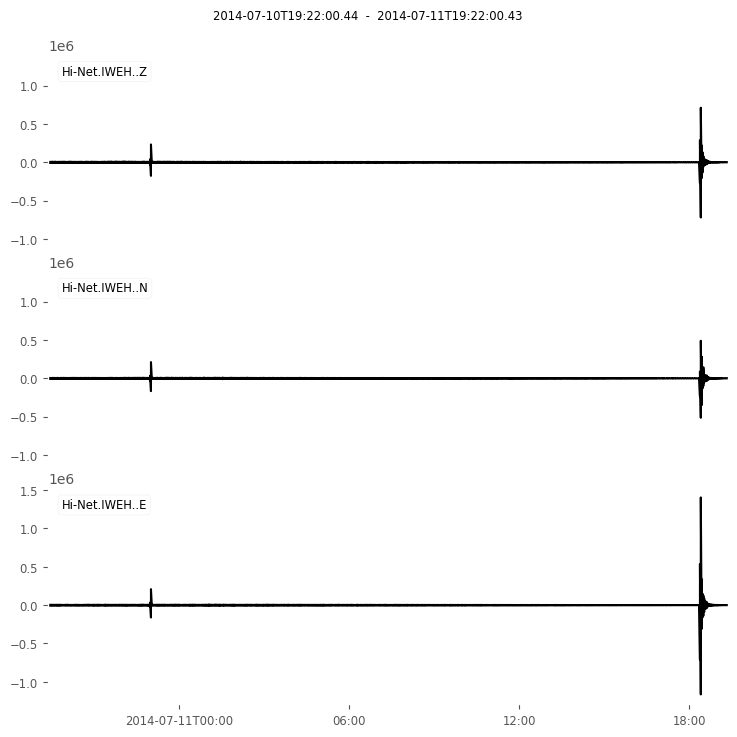

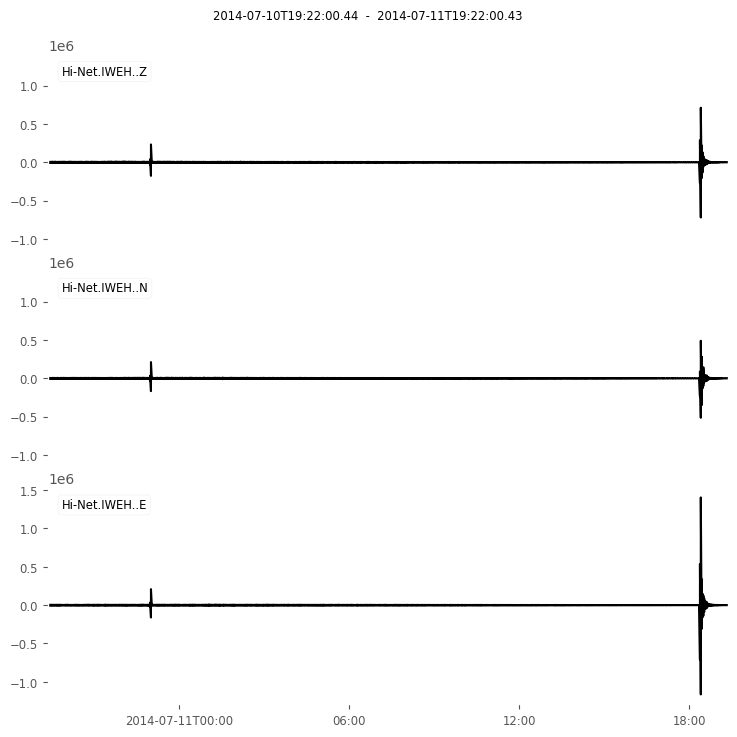

In [13]:
stream.plot()

减少噪声：去除趋势、合并潜在的非重叠段. 并在 1 Hz 以上对其进行高通滤波

3 Trace(s) in Stream:
Hi-Net.IWEH..E | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.IWEH..N | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.IWEH..Z | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples

3 Trace(s) in Stream:
Hi-Net.IWEH..E | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.IWEH..N | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.IWEH..Z | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples

3 Trace(s) in Stream:
Hi-Net.IWEH..E | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.IWEH..N | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.IWEH..Z | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples

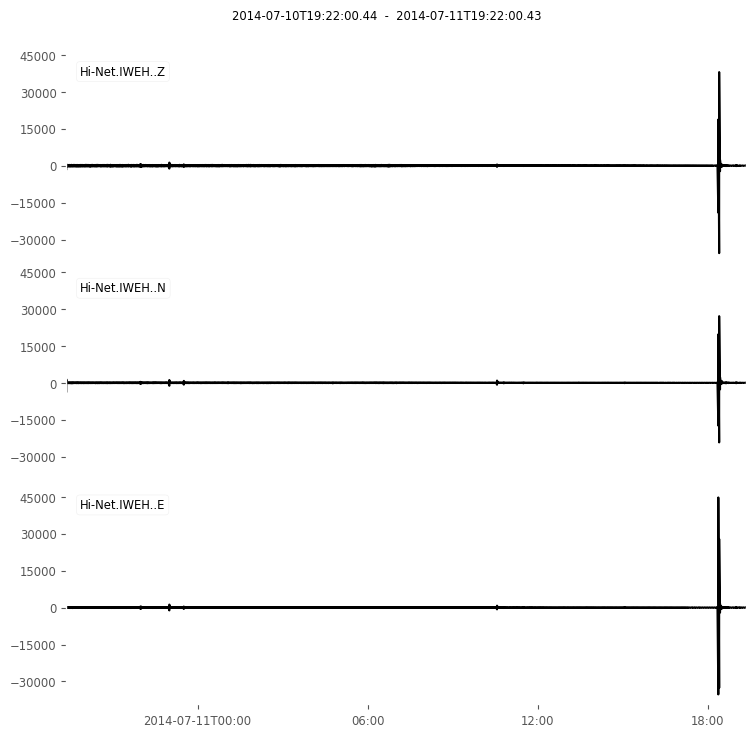

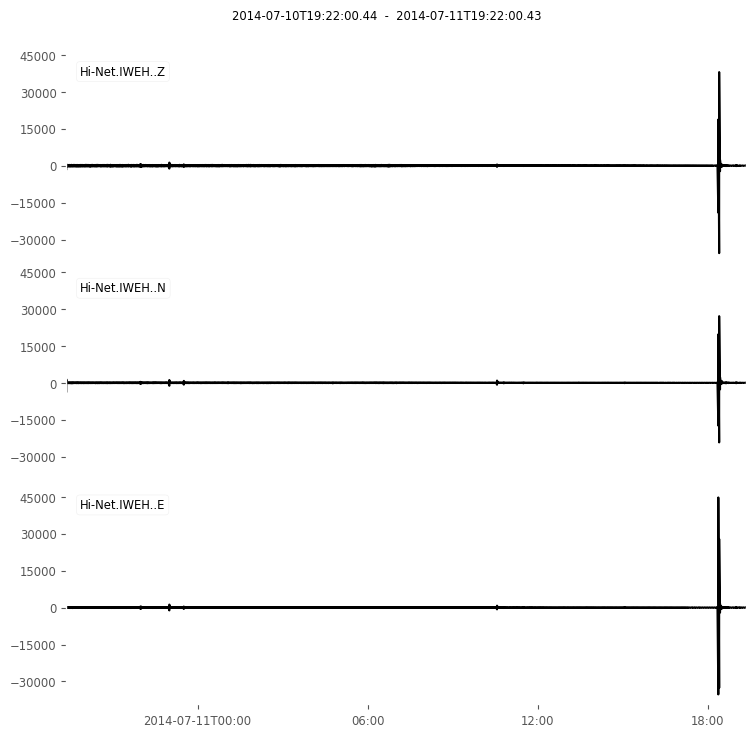

In [14]:
stream.merge(method=1)
stream.detrend("linear")
#stream1=stream.copy()
stream.filter(type="highpass", freq=1)
stream.plot(rasterized=True)

信号分成等长的段(3分钟一段, 保证信息足够充分)

In [15]:
# Extract segment length (from any layer)
segment_duration = network.bins / network.sampling_rate
overlap = 0.5

# Gather list for timestamps and segments
timestamps = list()
segments = list()

# Collect data and timestamps
for traces in stream.slide(segment_duration, segment_duration * overlap):
    timestamps.append(mdates.num2date(traces[0].times(type="matplotlib")[0]))
    segments.append(np.array([trace.data[:-1] for trace in traces]))

In [16]:
if segments[-1].shape != segments[-2].shape:
    padding = np.zeros((segments[-1].shape[0], segments[-2].shape[1] - segments[-1].shape[1]))
    segments[-1] = np.concatenate([segments[-1], padding], axis=1)

a=np.array(segments)
a.shape

(2879, 3, 6000)

把处理好的地震信号经过散射网络计算散射系数

In [17]:
scattering_coefficients = network.transform(segments, reduce_type=np.max)

In [18]:
sca=scattering_coefficients.copy()

In [19]:
scattering_coefficients=sca

观察单个通道结果

<ipython-input-20-1b940a37edc7>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax[1].pcolormesh(timestamps, center_frequencies, order_1.T, rasterized=True)


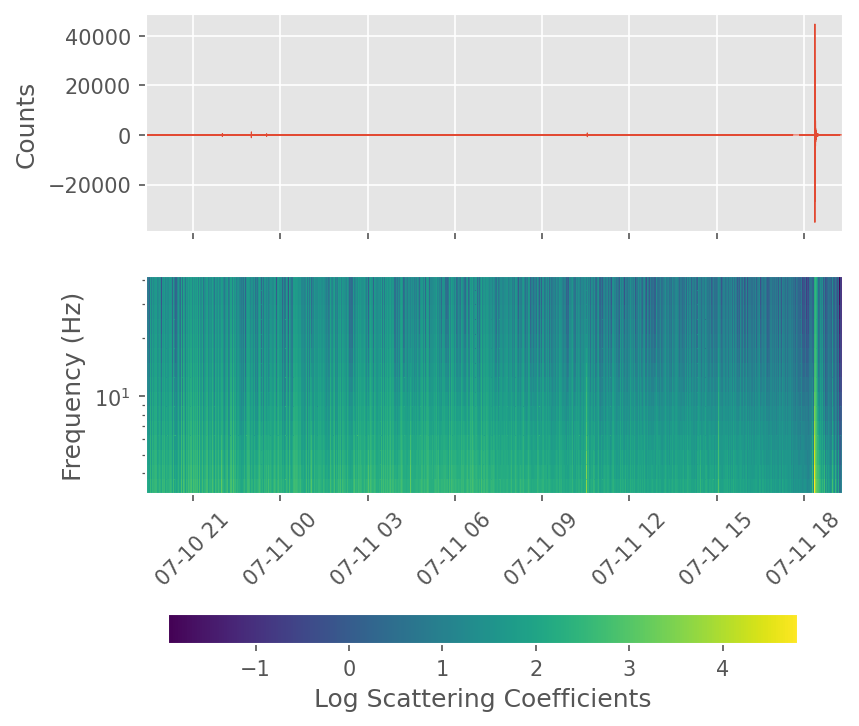

In [20]:
# 提取第一个通道
channel_id = 0
trace = stream[channel_id]
order_1 = np.log10(scattering_coefficients[0][:, channel_id, :].squeeze())
center_frequencies = network.banks[0].centers

# 创建图形和坐标轴
fig, ax = plt.subplots(2, sharex=True, dpi=150)

# 画出波形
ax[0].plot(trace.times("matplotlib"), trace.data, rasterized=True, lw=0.5)

# 画出一阶散射系数
cax = ax[1].pcolormesh(timestamps, center_frequencies, order_1.T, rasterized=True)

# 坐标轴标签
ax[1].set_yscale("log")
ax[0].set_ylabel("Counts")
ax[1].set_ylabel("Frequency (Hz)")
plt.xticks(rotation=45) 

# 添加颜色条
fig.subplots_adjust(bottom=0.1, top=0.9)
cbar_ax = fig.add_axes([0.15, -0.15, 0.7, 0.05])
fig.colorbar(cax, cax=cbar_ax, orientation='horizontal', label='Log Scattering Coefficients')

# 显示图形
plt.show();



+ 第一个子图就是前面的地震信号图.
+ 第二个子图是散射系数的谱分布图. 
  频率是地震学中的一个关键概念，它描述了地震波形中振动的快慢。频率越高，振动越快。散射系数是信号处理中的一个重要概念，它描述了信号在频域上的分布特性，具体来说，就是描述了信号在各个频率下的能量分布情况.
  图中的彩色图表示的是一阶散射系数（first-order scattering coefficients）随时间和频率的变化情况。彩色图的颜色深浅表示了一阶散射系数的大小，颜色趋于黄色，一阶散射系数越大，说明该频率下的能量越多.
  从图中可以看出，地震发生前，一阶散射系数的能量主要集中在低频段，随着时间的推移，能量逐渐向高频段转移，直到地震发生后，能量主要集中在高频段.

  

In [21]:
scattering_coefficients[0].shape

(2879, 3, 16)

### 降维提取特征

In [22]:
order_1.shape

(2879, 16)

In [23]:
order_1=scattering_coefficients[0]
order_2=scattering_coefficients[1]
times=timestamps

In [24]:
from sklearn.decomposition import FastICA

In [25]:
# Reshape and stack scattering coefficients of all orders
order_1 = order_1.reshape(order_1.shape[0], -1)
order_2 = order_2.reshape(order_2.shape[0], -1)
scattering_coefficients = np.hstack((order_1, order_2))

# transform into log
scattering_coefficients = np.log(scattering_coefficients)

# print info about shape
n_times, n_coeff = scattering_coefficients.shape
print("Collected {} samples of {} dimensions each.".format(n_times, n_coeff))

Collected 2879 samples of 528 dimensions each.


我们将散射系数降维，选取一些主要特征. 这里我们选取的是FastICA.

In [26]:
n_components=10
model = FastICA(n_components=n_components, whiten="unit-variance", random_state=123, max_iter=1000)
features = model.fit_transform(scattering_coefficients)

/Users/bubble/Anaconda3/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


画出每一个特征随时间的变化情况

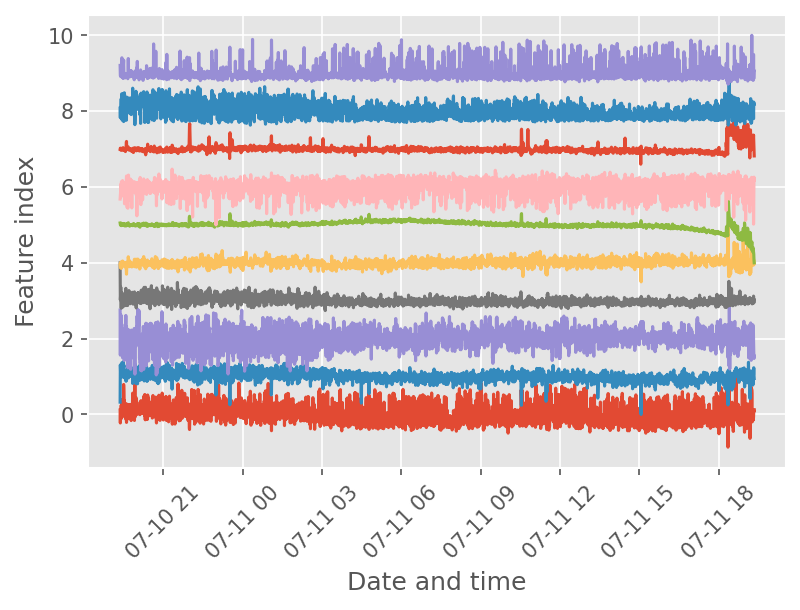

In [27]:
# Normalize features for display
features_normalized = features / np.abs(features).max(axis=0)

# Figure instance
fig = plt.figure(dpi=150)
ax = plt.axes()

# Plot features
ax.plot(times, features_normalized + np.arange(features.shape[1]), rasterized=True)

# Labels
ax.set_ylabel("Feature index")
ax.set_xlabel("Date and time")

plt.xticks(rotation=45) 
# Show
plt.show();

我们发现:
+ feature 5在地震发生的时候会剧烈增加，然后快速下降.
+ feature 7在地震发生前很平缓，地震发生后会剧烈增加.

所以我们猜测feature 5 和feature 7的信号与地震信号相关. 后续我们对这两个features的信号做进一步观察.

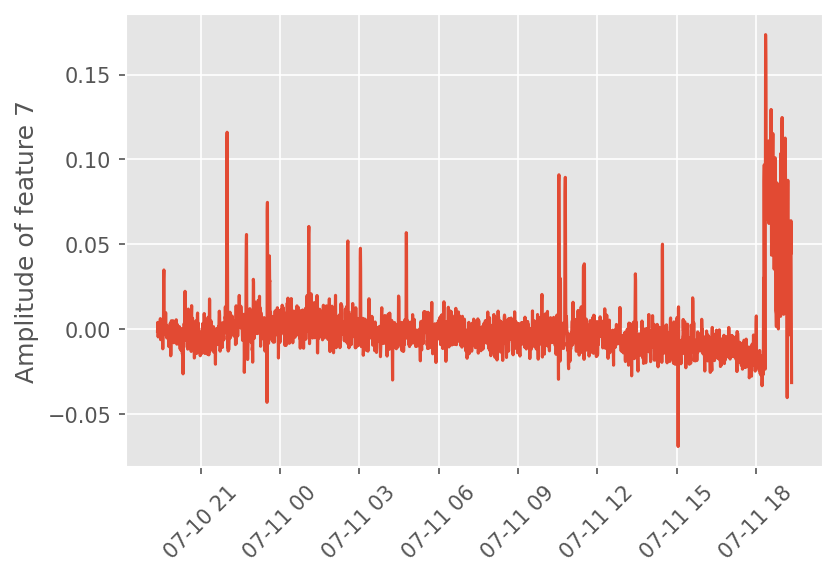

In [28]:
# Pick a feature
# cluster 7的情况
feature_id = 7
feature = features[:, feature_id]

# Figure creation
fig = plt.figure( dpi=150)
ax = plt.axes()

# Plot the weights
ax.plot(times, feature)
ax.set_ylabel(f"Amplitude of feature {feature_id}")
plt.xticks(rotation=45) 
# Show
plt.show();

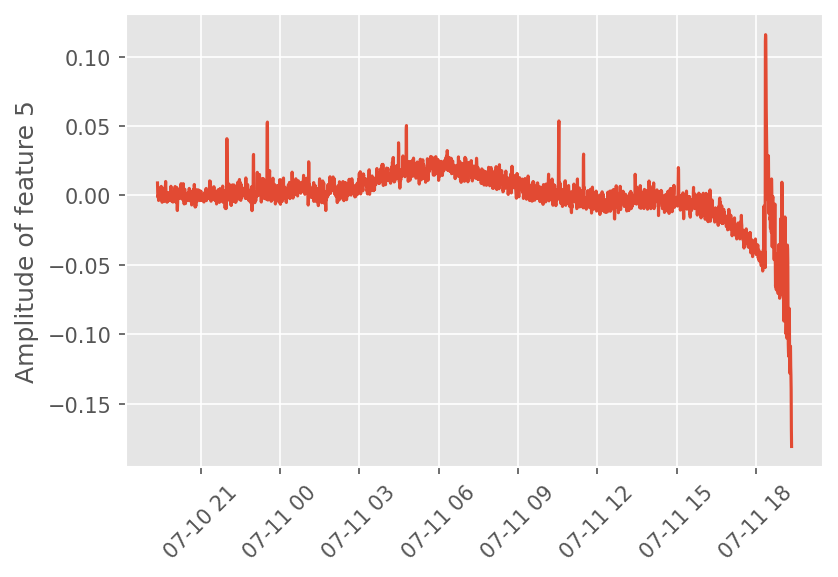

In [29]:
# Pick a feature
# cluster 5的情况
feature_id = 5
feature = features[:, feature_id]

# Figure creation
fig = plt.figure( dpi=150)
ax = plt.axes()

# Plot the weights
ax.plot(times, feature)
ax.set_ylabel(f"Amplitude of feature {feature_id}")
plt.xticks(rotation=45) 
# Show
plt.show();

In [30]:
# Etract weights from the dimensionality reduction model
weights = model.components_[feature_id]
vmax = np.abs(weights).max()

# Scattering coefficients shape and frequencies
n_cha = 3
n_order_1 = network.banks[0].octaves * network.banks[0].resolution
n_order_2 = network.banks[1].octaves * network.banks[1].resolution
f_1 = network.banks[0].centers
f_2 = network.banks[1].centers

# Extract and reshape weights
order_1 = weights[: n_cha * n_order_1].reshape(n_cha, n_order_1)
order_2 = weights[n_cha * n_order_1 :].reshape(n_cha, n_order_1, n_order_2)

<ipython-input-31-fc6e58e52b11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax[1, id].pcolormesh(f_1, f_2, order_2[id].T, **image_kw)
<ipython-input-31-fc6e58e52b11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax[1, id].pcolormesh(f_1, f_2, order_2[id].T, **image_kw)
<ipython-input-31-fc6e58e52b11>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specif

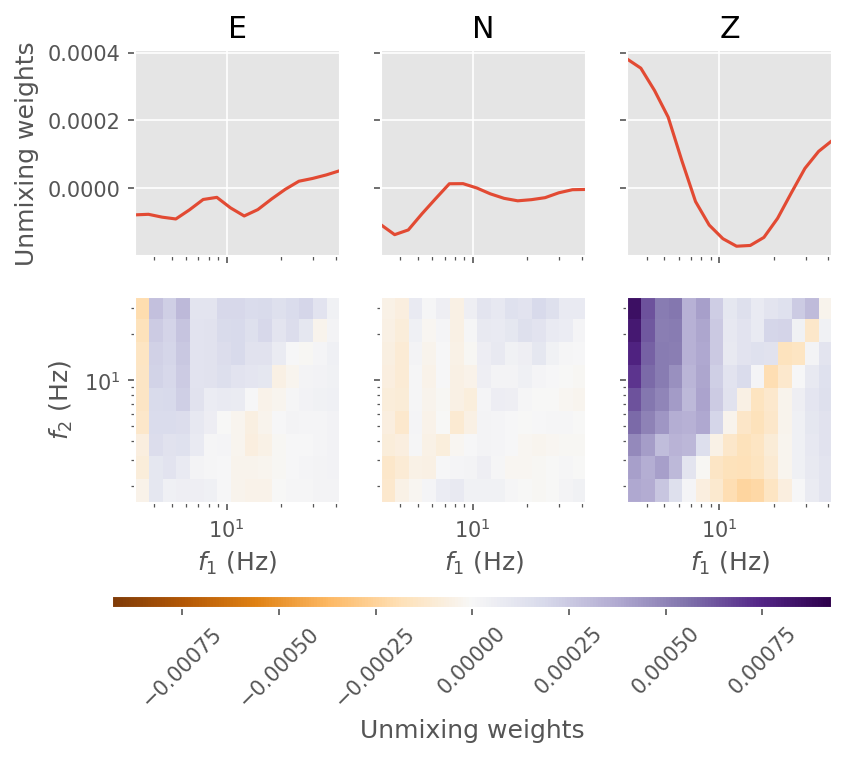

In [31]:
# Show weights
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey="row", dpi=150)
image_kw = dict(vmin=-vmax, vmax=vmax, rasterized=True, cmap="PuOr")
for id, channel in enumerate("ENZ"):

    # Show
    ax[0, id].plot(f_1, order_1[id], label=channel)
    mappable = ax[1, id].pcolormesh(f_1, f_2, order_2[id].T, **image_kw)

    # Labels
    ax[0, id].set_title(channel)
    ax[1, id].set_xlabel("$f_1$ (Hz)")

# Labels
ax[0, 0].set_ylabel("Unmixing weights")
ax[1, 0].set_ylabel("$f_2$ (Hz)")
ax[1, 0].set_xscale("log")
ax[1, 0].set_yscale("log")

# Colorbar
left, bottom, width, height =  0.1, -0.05, 0.8, 0.02  # Customize the position and size of the colorbar here.
cax = fig.add_axes([left, bottom, width, height])
colorbar = fig.colorbar(mappable, cax=cax, orientation="horizontal")
colorbar.set_label("Unmixing weights")
plt.xticks(rotation=45) 
# Show
plt.show();

这张图展示了混合权重(unmixing weights)的频率分布。混合权重是机器学习模型（通常是深度学习模型）在处理地震信号数据时，用来描述不同频率对于最终输出的贡献大小

混合权重（Unmixing weights）通常在源信号分离（如独立成分分析 ICA，盲源分离 BSS）的背景下被提到。源信号分离的目标是从一组混合信号中恢复出原始的独立源信号。在这个过程中，混合权重就是用来描述每个源信号对混合信号的贡献程度的参数。

更具体地说，如果你有一组信号，这些信号是由一些独立的源信号经过某种混合生成的，那么你可以通过学习混合权重来理解这个混合过程，并且如果可能的话，还可以用它来逆转这个混合过程，恢复出原始的源信号

+ 从图上我们可以看到:
  + 在E方向上，权重随频率增加而增大
  + 在N方向上，权重随频率先增后减，在10hz附近达到峰值
  + 在Z方向上，权重随频率先减后增，在10hz附近达到最低值

<ipython-input-32-b2c5945c6643>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax[id].pcolormesh(times, f_1, data, rasterized=True, vmin=vmin, vmax=vmax)


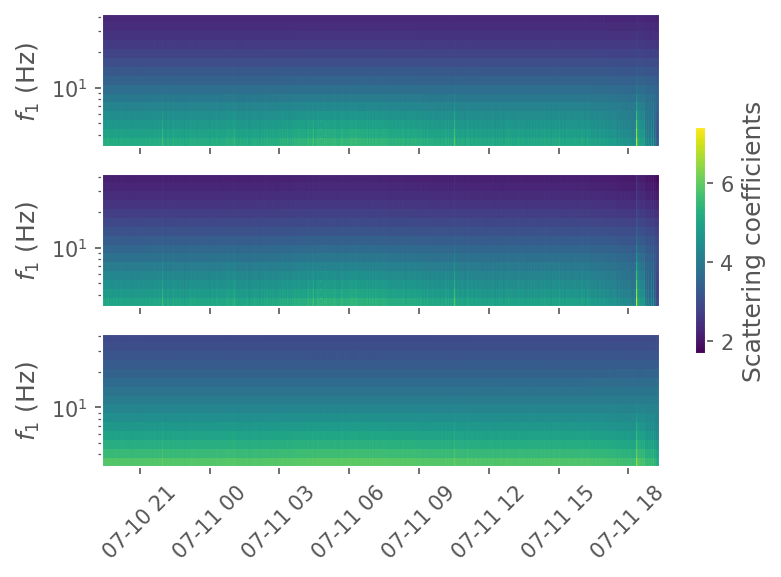

In [32]:
# Filter out latent space
feature_id=7
features_filtered = np.zeros(features.shape)
features_filtered[:, feature_id] = feature

# Extract all scattering coefficients
reconstructed = model.inverse_transform(features_filtered)
reconstructed_order_1 = reconstructed[:, : n_cha * n_order_1].reshape(-1, n_cha, n_order_1)
vmin = reconstructed_order_1.min()
vmax = reconstructed_order_1.max()

# Plot
fig, ax = plt.subplots(nrows=3, sharex=True, sharey="row", dpi=150)

# Plot
for id, channel in enumerate("ENZ"):
    data = reconstructed_order_1[:, id, :].squeeze().T
    mappable = ax[id].pcolormesh(times, f_1, data, rasterized=True, vmin=vmin, vmax=vmax)
    ax[id].set_ylabel("$f_1$ (Hz)")
    ax[id].set_yscale("log")

# Colorbar
colorbar = fig.colorbar(mappable, orientation="vertical", ax=ax, shrink=0.5)
colorbar.set_label("Scattering coefficients")
plt.xticks(rotation=45) 
plt.show();

In [33]:
from scipy import signal
from sklearn.cluster import KMeans

使用Kmeans 对特征进行聚类. 类别选10类. 这个效果还不错，后续可以再调整一下.

In [34]:
N_CLUSTERS = 10

# Perform clustering
model = KMeans(n_clusters=N_CLUSTERS, init="k-means++", random_state=123)
model.fit(features)

# Predict cluster for each sample
predictions = model.predict(features)

KMeans(n_clusters=10, random_state=123)

每一个类别的系数随时间变化情况

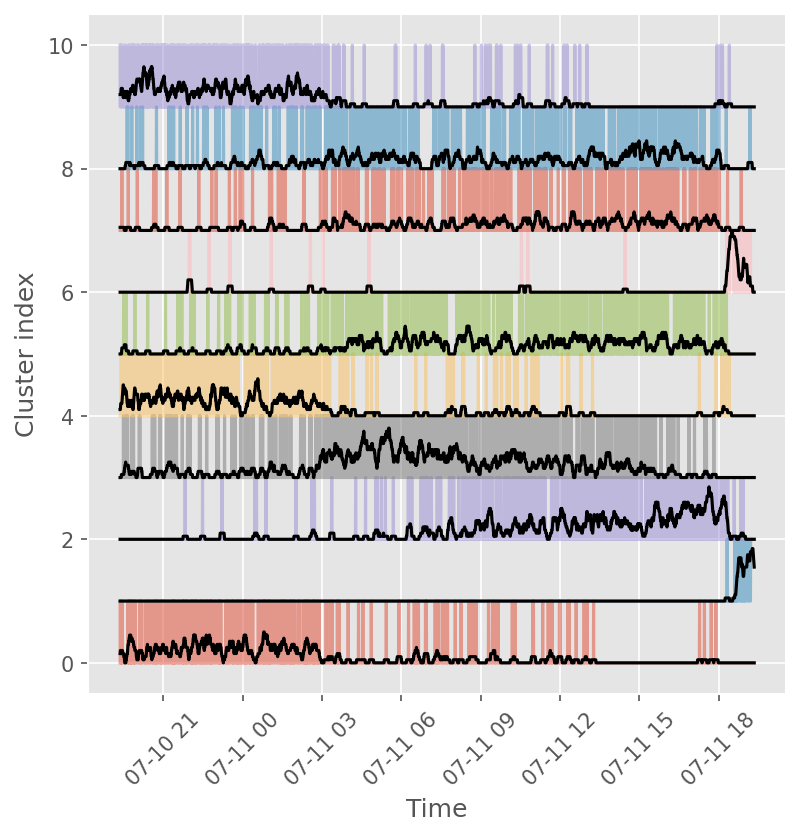

In [35]:
SMOOTH_KERNEL = 20

# Convert predictions to one-hot encoding
one_hot = np.zeros((len(times), N_CLUSTERS + 1))
one_hot[np.arange(len(times)), predictions] = 1

# Plot the results
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)

# Plot each cluster as a separate line
for i in range(N_CLUSTERS):

    # Obtain the detection rate by convolving with a boxcar kernel
    detection_rate = np.convolve(one_hot[:, i], np.ones(SMOOTH_KERNEL), mode="same") / SMOOTH_KERNEL

    # Plot the detection rate
    ax.plot(times, one_hot[:, i] + i, alpha=0.5)
    ax.plot(times, detection_rate + i, color="black")

# Labels
ax.set_xlabel("Time")
ax.set_ylabel("Cluster index")
plt.xticks(rotation=45) 
plt.show();

我们发现cluster1和cluster6在地震发生时间点有明显变化.单独观察一下变化曲线

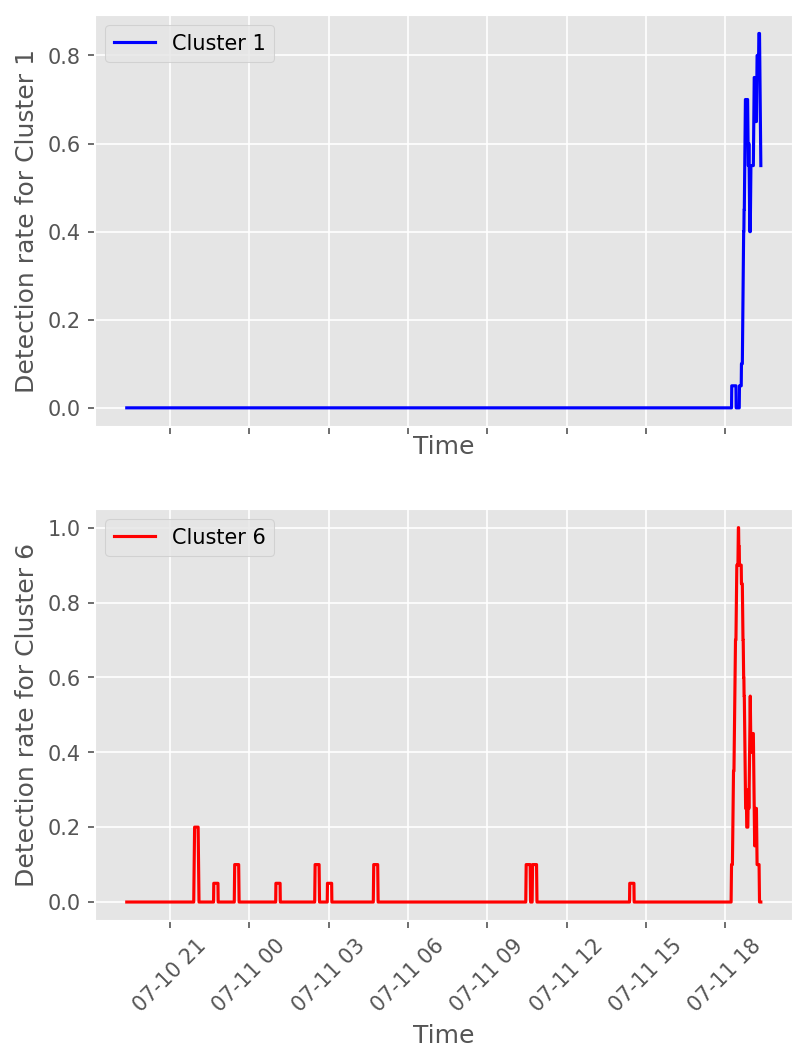

In [36]:
SMOOTH_KERNEL = 20

# Convert predictions to one-hot encoding
one_hot = np.zeros((len(times), N_CLUSTERS + 1))
one_hot[np.arange(len(times)), predictions] = 1

# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), dpi=150, sharex=True)

# Plot detection rate for cluster 2
detection_rate_1 = np.convolve(one_hot[:, 1], np.ones(SMOOTH_KERNEL), mode="same") / SMOOTH_KERNEL
ax1.plot(times, detection_rate_1, color="blue", label="Cluster 1")

# Labels for subplot 1
ax1.set_xlabel("Time")
ax1.set_ylabel("Detection rate for Cluster 1")
ax1.legend()
for label in ax1.get_xticklabels():
    label.set_rotation(45)

# Plot detection rate for cluster 6
detection_rate_6 = np.convolve(one_hot[:, 6], np.ones(SMOOTH_KERNEL), mode="same") / SMOOTH_KERNEL
ax2.plot(times, detection_rate_6, color="red", label="Cluster 6")

# Labels for subplot 2
ax2.set_xlabel("Time")
ax2.set_ylabel("Detection rate for Cluster 6")
ax2.legend()
for label in ax2.get_xticklabels():
    label.set_rotation(45)

plt.show();



研究这些clusters与前面的futures直接的相关性

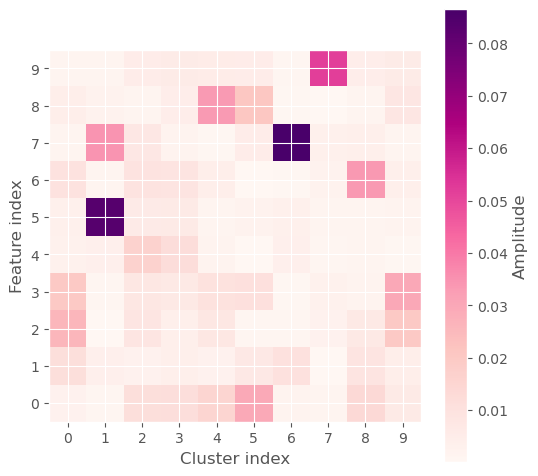

In [37]:
centroids = np.abs(model.cluster_centers_)

# Plot the centroids
fig = plt.figure(figsize=(6, 6), dpi=100)
ax = plt.axes()

# Show the centroids as a heatmap
mappable = ax.matshow(centroids.T, cmap="RdPu")

# Labels
plt.colorbar(mappable).set_label("Amplitude")
ax.set_xlabel("Cluster index")
ax.set_ylabel("Feature index")

# Ticks below
ax.xaxis.set_ticks_position("bottom")
ax.set_xticks(np.arange(N_CLUSTERS))
ax.set_yticks(np.arange(centroids.shape[1]))
ax.invert_yaxis()

# Show
plt.show();

每个cluster选出最具代表性的5个波形

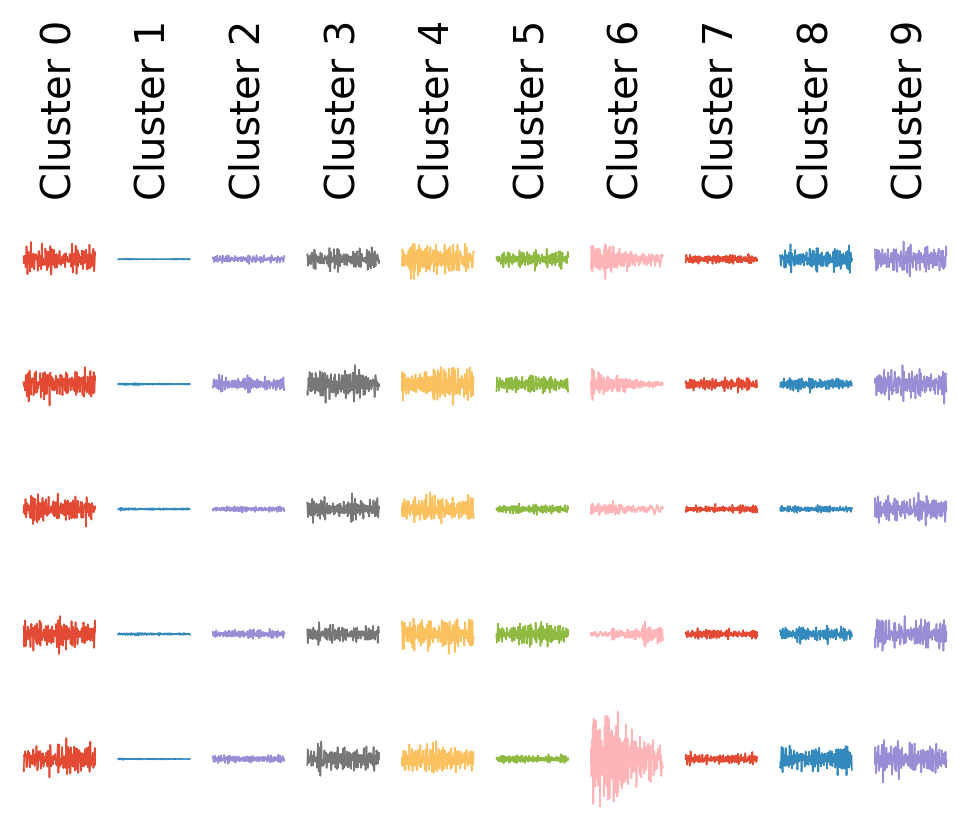

In [38]:
N_WAVEFORMS = 5

waveform_duration = network.bins / network.sampling_rate

# Extract waveforms
waveforms = list()
for cluster in np.unique(predictions):

    # Calculate the distance of each sample to the cluster mean
    mean = np.mean(features[predictions == cluster], axis=0)
    distance = np.linalg.norm(features[predictions == cluster] - mean, axis=1)
    
    # Convert boolean array to integer indices
    indices = np.where(predictions == cluster)[0]
    closest_indices = indices[distance.argsort()[:N_WAVEFORMS]]
    closest = [times[i] for i in closest_indices]

    # Collect closest waveforms in a list
    traces = list()
    for time in closest[:N_WAVEFORMS]:
        time = UTCDateTime(time)
        trace = stream.slice(time, time + waveform_duration)[0].copy() 
        traces.append(trace)
    waveforms.append(traces)

# Plot the results
fig, ax = plt.subplots(N_WAVEFORMS, N_CLUSTERS, sharex=True, sharey=True, dpi=200)

# Plot each cluster as a separate line
for i, traces in enumerate(waveforms):
    ax[0, i].set_title(f"Cluster {i}", rotation="vertical")
    for j, trace in enumerate(traces):
        ax[j, i].plot(trace.times(), trace.data, rasterized=True, lw=0.6, color=f"C{i}")
        ax[j, i].set_axis_off()

# Show
plt.show();

观察cluster 1和cluster 6的波形

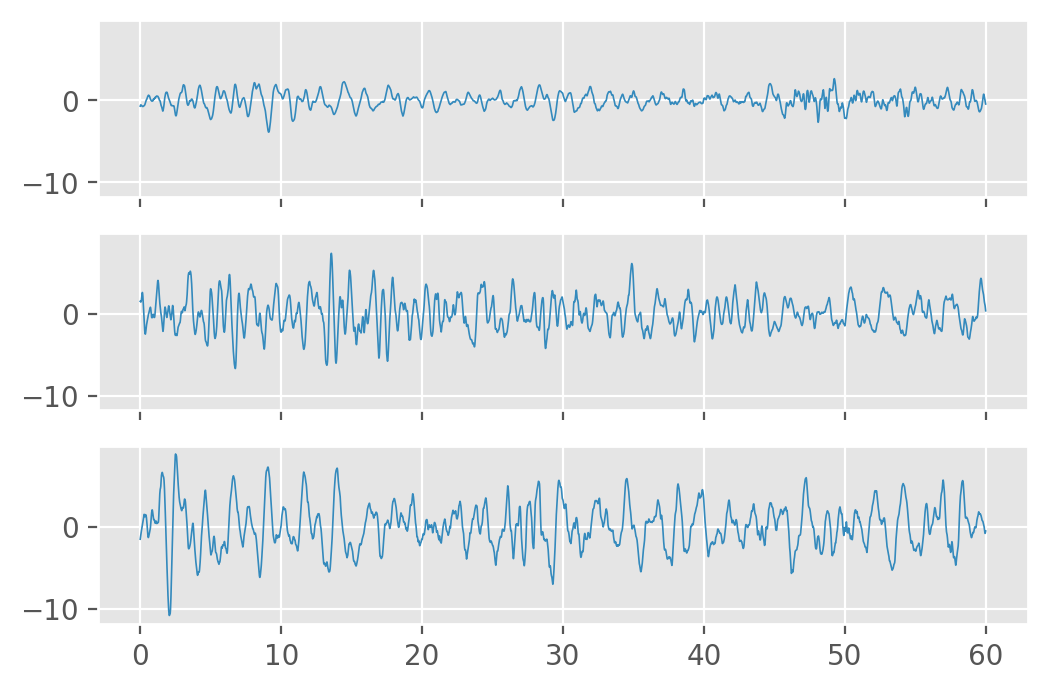

In [39]:
N_WAVEFORMS = 3

waveform_duration = network.bins / network.sampling_rate

# Extract waveforms for cluster 1
cluster = 1
waveforms = list()

# Calculate the distance of each sample to the cluster mean
mean = np.mean(features[predictions == cluster], axis=0)
distance = np.linalg.norm(features[predictions == cluster] - mean, axis=1)

# Convert boolean array to integer indices
indices = np.where(predictions == cluster)[0]
closest_indices = indices[distance.argsort()[:N_WAVEFORMS]]
closest = [times[i] for i in closest_indices]

# Collect closest waveforms in a list
traces = list()
for time in closest[:N_WAVEFORMS]:
    time = UTCDateTime(time)
    trace = stream.slice(time, time + waveform_duration)[0].copy() 
    traces.append(trace)
waveforms.append(traces)

# Plot the results
fig, ax = plt.subplots(N_WAVEFORMS, 1, sharex=True, sharey=True, dpi=200)

# Plot each waveform for cluster 1
for i, trace in enumerate(traces):
    ax[i].plot(trace.times(), trace.data, rasterized=True, lw=0.6, color=f"C{cluster}")

plt.show();



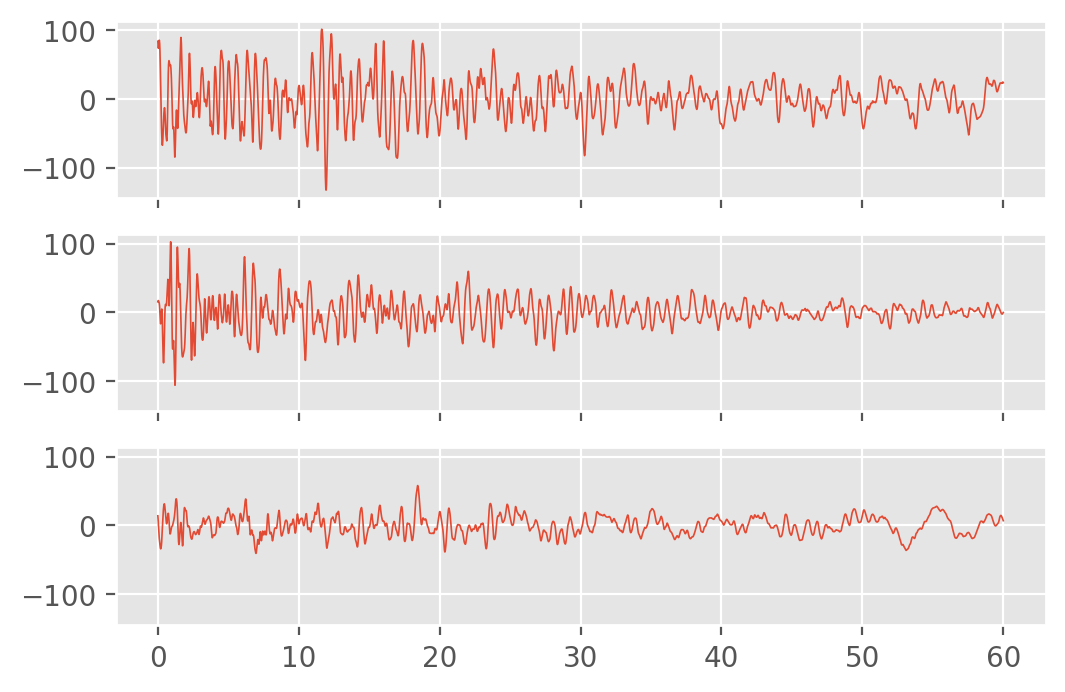

In [40]:
N_WAVEFORMS = 3

waveform_duration = network.bins / network.sampling_rate

# Extract waveforms for cluster 1
cluster = 6
waveforms = list()

# Calculate the distance of each sample to the cluster mean
mean = np.mean(features[predictions == cluster], axis=0)
distance = np.linalg.norm(features[predictions == cluster] - mean, axis=1)

# Convert boolean array to integer indices
indices = np.where(predictions == cluster)[0]
closest_indices = indices[distance.argsort()[:N_WAVEFORMS]]
closest = [times[i] for i in closest_indices]

# Collect closest waveforms in a list
traces = list()
for time in closest[:N_WAVEFORMS]:
    time = UTCDateTime(time)
    trace = stream.slice(time, time + waveform_duration)[0].copy() 
    traces.append(trace)
waveforms.append(traces)

# Plot the results
fig, ax = plt.subplots(N_WAVEFORMS, 1, sharex=True, sharey=True, dpi=200)

# Plot each waveform for cluster 1
for i, trace in enumerate(traces):
    ax[i].plot(trace.times(), trace.data, rasterized=True, lw=0.6, color=f"C{cluster+1}")

plt.show();

